In [12]:
import shap
import torch
import torch.nn as nn
import sys
import os

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout), # - Nochmals prüfen, ob wirklich notwendig vlt auslassen  
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            #nn.Linear(input_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            #nn.ReLU(),
            #nn.Dropout(dropout),
            ResidualBlock(input_dim, dropout),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout) # Im Transformer Dropout ohne versuchen / Sequentiell ja () Anders Paper noch - wie sie es gmacht haben im AB 
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class LazyTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings,
                 trbv_dict, trbj_dict, mhc_dict):
        self.data_frame = data_frame
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

        # Dictionary-Zuweisung
        self.trbv_dict = trbv_dict
        self.trbj_dict = trbj_dict
        self.mhc_dict = mhc_dict

        # Berechne UNKNOWN-Indices
        self.unknown_trbv_idx = len(trbv_dict)
        self.unknown_trbj_idx = len(trbj_dict)
        self.unknown_mhc_idx = len(mhc_dict)

        self.data_frame["TRBV_Index"] = data_frame["TRBV"].map(trbv_dict).fillna(self.unknown_trbv_idx).astype(int)
        self.data_frame["TRBJ_Index"] = data_frame["TRBJ"].map(trbj_dict).fillna(self.unknown_trbj_idx).astype(int)
        self.data_frame["MHC_Index"] = data_frame["MHC"].map(mhc_dict).fillna(self.unknown_mhc_idx).astype(int)

        # Sicherheit
        assert self.data_frame["TRBV_Index"].max() < (self.unknown_trbv_idx + 1), "TRBV_Index out of range!"
        assert self.data_frame["TRBJ_Index"].max() < (self.unknown_trbj_idx + 1), "TRBJ_Index out of range!"
        assert self.data_frame["MHC_Index"].max() < (self.unknown_mhc_idx + 1), "MHC_Index out of range!"


    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        tcr_id = sample["TRB_CDR3"]
        epitope_id = sample["Epitope"]
        label = sample["Binding"]

        tcr_embedding = self.tcr_embeddings[tcr_id][:]
        epitope_embedding = self.epitope_embeddings[epitope_id][:]

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(sample["TRBV_Index"], dtype=torch.long),
            torch.tensor(sample["TRBJ_Index"], dtype=torch.long),
            torch.tensor(sample["MHC_Index"], dtype=torch.long),
            torch.tensor(label, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.data_frame)


class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=20, max_epitope_length=15,
             dropout=0.1, classifier_hidden_dim=64,
             trbv_vocab_size=50, trbj_vocab_size=20, mhc_vocab_size=100):
        super(TCR_Epitope_Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)
        self.trbv_embed = nn.Embedding(trbv_vocab_size, embed_dim, padding_idx=trbv_vocab_size - 1)
        self.trbj_embed = nn.Embedding(trbj_vocab_size, embed_dim, padding_idx=trbj_vocab_size - 1)
        self.mhc_embed  = nn.Embedding(mhc_vocab_size,  embed_dim, padding_idx=mhc_vocab_size - 1)
         
        #self.tcr_bn = nn.BatchNorm1d(max_tcr_length) # Wieso? Nochmals prüfen, ob notwendig -
        #self.epitope_bn = nn.BatchNorm1d(max_epitope_length) # Wieso? Nochmals prüfen, ob notwendig -

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        #self.classifier_input_dim = embed_dim * 2
        #self.classifier_input_dim = (max_tcr_length + max_epitope_length) * embed_dim
        #self.classifier_input_dim = embed_dim * 5
        
        #self.classifier_input_dim = 11392 
        self.classifier_input_dim = (max_tcr_length + max_epitope_length) * embed_dim + 3 * embed_dim

        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)


    def forward(self, tcr, epitope, trbv, trbj, mhc, return_combined_features=False):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)
        trbv_embed = self.trbv_embed(trbv).squeeze(1)
        trbj_embed = self.trbj_embed(trbj).squeeze(1)
        mhc_embed = self.mhc_embed(mhc).squeeze(1)

        # Optional: normalize across sequence
        #tcr_emb = self.tcr_bn(tcr_emb)
        #epitope_emb = self.epitope_bn(epitope_emb)

        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)

        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]

        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)

        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)

        # Flatten the combined sequences + embeddings
        flattened = combined.view(combined.size(0), -1)

        # Alle Merkmale (TCR, Epitope, MHC, TRBV, TRBJ) für den Klassifikator zusammenführen
        combined_features = torch.cat([flattened, trbv_embed, trbj_embed, mhc_embed], dim=1)

        output = self.classifier(combined_features).squeeze(1)       

        if return_combined_features:
            return combined_features

        return output

In [14]:

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))
# from models.morning_stars_v1.beta.v2_only_res_noBNpre_flatten import TCR_Epitope_Transformer, LazyTCR_Epitope_Dataset


model = TCR_Epitope_Transformer()
model.eval()  # Important for SHAP


TCR_Epitope_Transformer(
  (tcr_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (epitope_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (trbv_embed): Embedding(50, 128, padding_idx=49)
  (trbj_embed): Embedding(20, 128, padding_idx=19)
  (mhc_embed): Embedding(100, 128, padding_idx=99)
  (transformer_layers): ModuleList(
    (0-1): 2 x AttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    

In [15]:
# Example dummy shapes – replace with actual data
# All tensors should be torch.Tensor of shape: [batch_size, ...]
tcr = torch.randn(10, 20, 1024)            # 10 samples, max_tcr_length=20
epitope = torch.randn(10, 15, 1024)        # 10 samples, max_epitope_length=15
trbv = torch.randint(0, 50, (10, 1))       # vocab size 50
trbj = torch.randint(0, 20, (10, 1))       # vocab size 20
mhc = torch.randint(0, 100, (10, 1))       # vocab size 100

# For explanation, use a single example or small batch
explainer_input = (tcr, epitope, trbv, trbj, mhc)


/tmp/ipykernel_20749/2241255557.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=sample.cpu().numpy())
/home/ubuntu/anaconda3/lib/python3.12/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

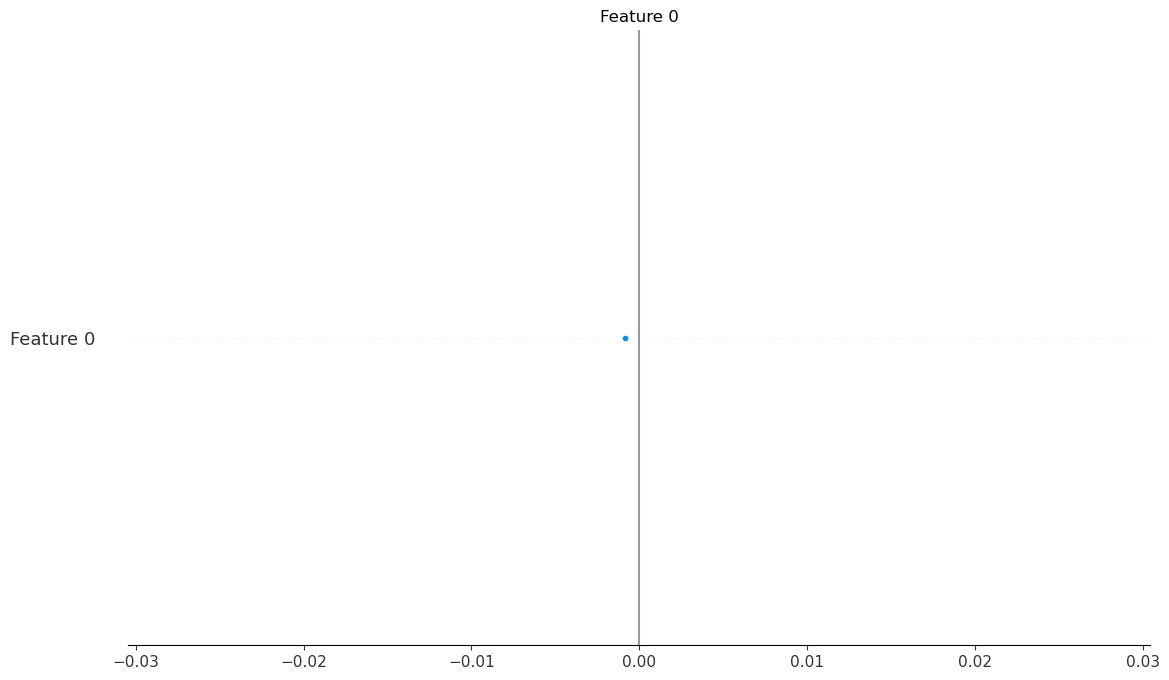

In [17]:
# 1. Forward pass through transformer -> get combined_features
with torch.no_grad():
    combined_features = model.forward(
        tcr, epitope, trbv, trbj, mhc, return_combined_features=True
    )

# 2. Define classifier-only model
classifier = model.classifier

# 3. Create SHAP explainer on the classifier
explainer = shap.GradientExplainer(classifier, combined_features)

# 4. Choose a single sample to explain
sample = combined_features[0:1]

# 5. Compute SHAP values
shap_values = explainer.shap_values(sample)

# 6. Visualize
shap.summary_plot(shap_values, features=sample.cpu().numpy())


In [25]:
print(sample.shape)
print(shap_values.shape)

torch.Size([1, 4864])
(1, 4864, 1)


In [29]:
# Fix shape: shap_values[0] is (4864, 1) → transpose to (1, 4864)
shap_array = shap_values[0].T  # Now shape is (1, 4864)


In [36]:
# Transpose once to get shape (1, 4864)
shap_array = shap_values[0].T  # shape: (1, 4864)

# Split up into regions
tcr_shap     = shap_array[:, 0:2560]
epitope_shap = shap_array[:, 2560:4480]
trbv_shap    = shap_array[:, 4480:4608]
trbj_shap    = shap_array[:, 4608:4736]
mhc_shap     = shap_array[:, 4736:4864]

# Optional: reshape TCR SHAP for visualization
tcr_shap_values = tcr_shap.reshape(1, 20, 128)  # shape: (1, TCR_length, embed_dim)
# tcr_importance_per_pos = tcr_shap_values.abs().sum(dim=2).squeeze(0)  # shape: (20,)


# Convert to tensor
tcr_shap_tensor = torch.tensor(tcr_shap, dtype=torch.float32)  # shape: (1, 2560)

# Reshape to (1, 20, 128)
tcr_shap_values = tcr_shap_tensor.reshape(1, 20, 128)

# Aggregate SHAP values per position
tcr_importance_per_pos = tcr_shap_values.abs().sum(dim=2).squeeze(0)  # shape: (20,)



In [32]:
print(shap_array.shape)
print(tcr_shap.shape)
print(epitope_shap.shape)
print(trbv.shape)
print(trbj.shape)
print(mhc_shap.shape)

(1, 4864)
(1, 2560)
(1, 1920)
torch.Size([10, 1])
torch.Size([10, 1])
(1, 128)


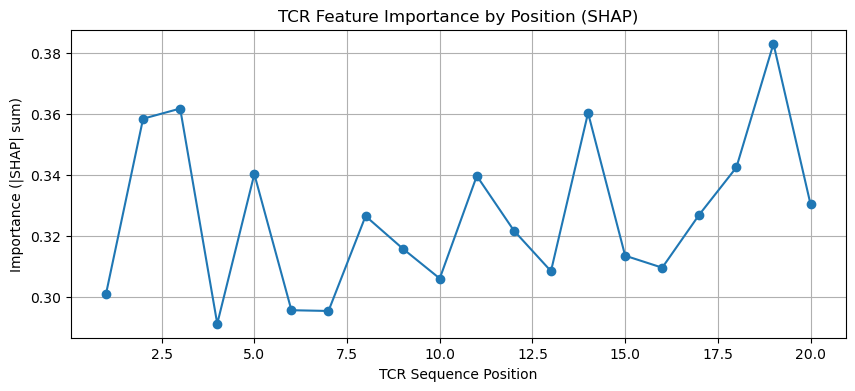

In [37]:
# # Reshape to (batch_size, sequence_length, embedding_dim)
# tcr_shap_values = tcr_shap.reshape(1, 20, 128)  # shape: (1, 20, 128)

# # Aggregate importance by TCR position
# tcr_importance_per_pos = tcr_shap_values.abs().sum(dim=2).squeeze(0)  # (20,)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(range(1, 21), tcr_importance_per_pos.cpu().numpy(), marker='o')
plt.title("TCR Feature Importance by Position (SHAP)")
plt.xlabel("TCR Sequence Position")
plt.ylabel("Importance (|SHAP| sum)")
plt.grid(True)
plt.show()


In [38]:
# Your decoded sequences
tcr_aa_sequence = "CASSFGQRDRGYWRNTEAFF"   # Length = 20
epitope_aa_sequence = "ARNLVPMVATVQGQN"  # Length = 15


In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from IPython.display import display, HTML

def color_sequence_by_importance(sequence, importances, cmap_name="Reds"):
    """
    Returns an HTML string with amino acids colored by importance values.
    """
    cmap = cm.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=0, vmax=max(importances))
    
    html_str = ""
    for aa, score in zip(sequence, importances):
        rgba = cmap(norm(score))
        color = mcolors.to_hex(rgba)
        html_str += f'<span style="background-color:{color};padding:2px;">{aa}</span>'
    
    return html_str


In [41]:
# Example usage
tcr_html = color_sequence_by_importance(tcr_aa_sequence, tcr_importance_per_pos)
# epitope_html = color_sequence_by_importance(epitope_aa_sequence, epitope_importance_per_pos)

# Display in notebook
display(HTML(f"<h4>TCR Sequence SHAP Overlay</h4>{tcr_html}"))
# display(HTML(f"<h4>Epitope Sequence SHAP Overlay</h4>{epitope_html}"))


/tmp/ipykernel_20749/4162379589.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


In [ ]:
import shap
import torch

class CustomModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        # Unpack tuple to pass to the original model
        return self.model(*inputs)
        
wrapped_model = CustomModelWrapper(model)


In [8]:
# explainer = shap.GradientExplainer(wrapped_model, explainer_input)
# # Or use DeepExplainer if all ops are supported
# # explainer = shap.DeepExplainer(wrapped_model, explainer_input)

explainer = shap.Explainer(wrapped_model, explainer_input)


In [9]:
sample_input = (
    tcr[0:1],
    epitope[0:1],
    trbv[0:1],
    trbj[0:1],
    mhc[0:1]
)

shap_values = explainer(sample_input)


ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 40961!

In [ ]:
# # Flatten the feature input as needed (e.g., combined_features shape)
# # Visualize one component (e.g., total importance)
# shap_values_tensor = torch.cat([v.reshape(1, -1) for v in shap_values], dim=1)
# shap.summary_plot(shap_values_tensor.detach().numpy())

shap.plots.waterfall(shap_values[0][0])  # 0 = tcr embedding SHAP, second 0 = first sample

